# Optimization of the lamination scheme of a multi-layered shell using a Genetic Algorithm

We are going to optimize a multi layered plate under the action of one deterministic, static load case. The objective is the sum of the volume and the penalties dues to constraint violations, the constraints being an upper limit on the maximum deflection and an upper limit on the maximum utilization. The subject of the study is a simply supported plate and calculation of the unknown displacement field is carried out using Navier's harmonic solution. Failure is modeled using a simple Huber-Mises-Hencky criterion using the goodies of `sigmaepsilon.solid.material`. For optimization, we use a Genetic Algorithm from `sigmaepsilon.math`.

In [29]:
from numpy import ascontiguousarray as ascont
import numpy as np

from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    RectangleLoad,
)

size = Lx, Ly = (600.0, 800.0)
shape = nx, ny = (20, 20)
grid_shape = (10, 10)

E_1 = 2890.0
nu_1 = 0.2
rho_1 = 100.0
yield_strength_1 = 25.0

E_2 = 2460.0
nu_2 = 0.25
rho_2 = 150.0
yield_strength_2 = 18.0

num_layers = 6


def mirror_list(input_list: list) -> list:
    """
    Takes a list as input and returns a new list.
    The new list consists of the original list followed by its reversed version.
    """
    return input_list + input_list[::-1]


def random_in_interval(a, b) -> np.ndarray:
    """
    Returns a random floating-point number N such that a <= N <= b.
    """
    return np.random.uniform(a, b)


def custom_layer(angle_rad, E, NU, YS, t):
    hooke = elastic_stiffness_matrix(E=E, NU=NU)
    frame = ReferenceFrame(dim=3)
    stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)
    stiffness.orient('Body', [0, 0, angle_rad], 'XYZ')
    failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=YS)
    material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)
    layer = Section.Layer(material=material, thickness=t)
    return layer
    

def generate_data(angles_rad: list, thicknesses: list, materials:list):  
    layers = []
    for angle_rad, t, (E, NU, YS) in zip(
        mirror_list(angles_rad), 
        mirror_list(thicknesses), 
        mirror_list(materials)
    ):
        layers.append(custom_layer(angle_rad, E, NU, YS, t))

    section = Section(layers=layers)
    ABDS = section.elastic_stiffness_matrix()
    D, S = ascont(ABDS[:3, :3]), ascont(ABDS[3:, 3:])

    loads = LoadGroup(
        LG1=LoadGroup(
            LC1=RectangleLoad(x=[[Lx / 3, Ly / 2], [Lx / 2, 2 * Ly / 3]], v=[-1, 0, 0]),
        )
    )
    loads.lock()

    gridparams = {"size": size, "shape": shape, "eshape": "Q4"}
    coords, topo = grid(**gridparams)
    coords, triangles = Q4_to_T3(coords, topo)
    triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]

    plate = RectangularPlate(size, grid_shape, D=D, S=S)
    results = plate.solve(loads, coords)
    
    return section, results, coords, triobj


def postproc_utils(results, section, coords, t):
    load_case_results = results["LG1", "LC1"].values
    strains = load_case_results[:, 3:8]
    dofsol = load_case_results[:, :3]
    z, rng = np.linspace(-t/2, t/2, 100), (-t/2, t/2)
    util, util_coords = section.utilization(strains=strains, rng=rng, z=z, coords=coords, return_coords=True)
    return dofsol, util, util_coords


In [30]:
angles_rad = [0.0, np.pi/2, 0.0]
thicknesses = [10, 10, 10]
materials = [(E_1, nu_1, yield_strength_1), (E_2, nu_2, yield_strength_2), (E_1, nu_1, yield_strength_1)]
densities = [rho_1, rho_2, rho_1]
section, results, coords, triobj = generate_data(angles_rad, thicknesses, materials)
thickness = np.sum(thicknesses) * 2
dofsol, util, util_coords = postproc_utils(results, section, coords, thickness)

In [31]:
util.max(), (np.abs(dofsol[:, 0]).max(), min(size) / 200)

(<xarray.DataArray ()>
 array(0.19363115),
 (1.1748732800228634, 3.0))

In [32]:
from sigmaepsilon.math.optimize import BinaryGeneticAlgorithm as BGA

num_x = num_layers // 2
assert num_layers % 2 == 0

displacement_constraint = min(size) / 200

materials, densities = [], []
for i in range(num_x):
    rnd = np.random.rand()
    material = (E_1, nu_1, yield_strength_1) if rnd < 0.5 else (E_2, nu_2, yield_strength_2)
    density = rho_1 if rnd < 0.5 else rho_2
    materials.append(material)
    densities.append(density)
    

def objective(x):
    x = transform_result(x)
    num_layers = len(x) // 2
    thicknesses = x[:num_layers]
    
    mass = 0
    for thickness, density in zip(thicknesses, densities):
        mass += thickness * density * 2
    
    return mass + constraint_violations(x)


def constraint_violations(x):
    num_layers = len(x) // 2
    thicknesses = x[:num_layers]
    angles_rad = x[num_layers:]
    thickness = calculate_thickness(x)
    
    result = 0
    
    section, results, coords, _ = generate_data(angles_rad, thicknesses, materials)
    dofsol, util, _ = postproc_utils(results, section, coords, thickness)
    
    max_displacement = np.abs(dofsol[:, 0]).max()
    if not max_displacement <= displacement_constraint:
        result += 1e12
    
    max_utilization = float(util.values.max())
    if not max_utilization <= 1.0:
        result += 1e12
    
    return result


def calculate_thickness(x) -> float:
    num_layers = len(x) // 2
    return sum(x[:num_layers]) * 2


def transform_result(x):
    num_x = len(x) // 2
    thicknesses = x[:num_x]
    angles_rad = x[num_x:]
    _angles_rad = []
    for angle in angles_rad:
        if angle < 0.5:
            _angles_rad.append(0.0)
        else:
            _angles_rad.append(np.pi/2)
    angles_rad = _angles_rad
    return thicknesses + angles_rad

100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


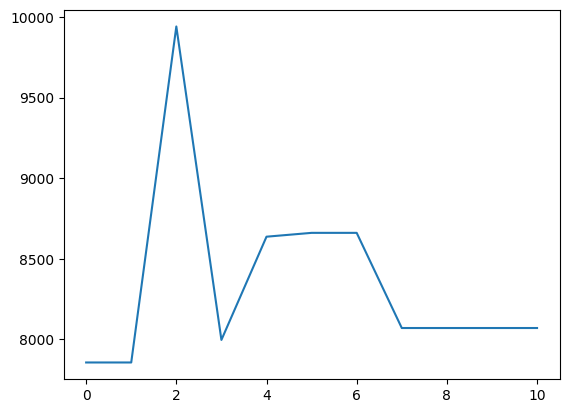

In [33]:
import matplotlib.pyplot as plt
from tqdm import tqdm

range_thicknesses = [[0.1, 20],] * num_x
range_angles = [[0, 1],] * num_x
ranges = range_thicknesses + range_angles

BGA = BGA(objective, ranges, length=12, nPop=20)
history = [objective(BGA.best_phenotype())]

for _ in tqdm(range(10)):
    BGA.evolve(1)
    history.append(objective(BGA.best_phenotype()))
    
plt.plot(history)
plt.show()

x = BGA.best_phenotype()

In [34]:
objective(x)

8069.848595848594

In [35]:
x = transform_result(x)
constraint_violations(x)

0

In [36]:
thicknesses = x[:num_x]
angles_rad = x[num_x:]
thickness = calculate_thickness(x)

section, results, coords, triobj = generate_data(angles_rad, thicknesses, materials)
dofsol, util, util_coords = postproc_utils(results, section, coords, thickness)

In [37]:
thicknesses, angles_rad

([15.922808302808301, 2.097289377289377, 14.367741147741146],
 [0.0, 1.5707963267948966, 0.0])

In [38]:
import numpy as np
import pyvista as pv

thickness = calculate_thickness(x)

load_case_results = results["LG1", "LC1"].values
strains = load_case_results[:, 3:8]
z = np.linspace(-thickness/2, thickness/2, 20)
rng = (-thickness/2, thickness/2)
stresses = section.calculate_stresses(strains=strains, rng=rng, z=z).values
util, util_coords = section.utilization(strains=strains, rng=rng, z=z, coords=coords, return_coords=True)

dofsol, util, util_coords = postproc_utils(results, section, coords, thickness)

num_XY, num_Z = util_coords.shape[:2]
util_coords = util_coords.reshape((num_XY * num_Z, 3))
util = util.values.flatten()

point_cloud = pv.PolyData(util_coords)
point_cloud["scalars"] = util

point_cloud

PolyData (0x2379c4dbe20)
  N Cells:    44100
  N Points:   44100
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -3.239e+01, 3.239e+01
  N Arrays:   1

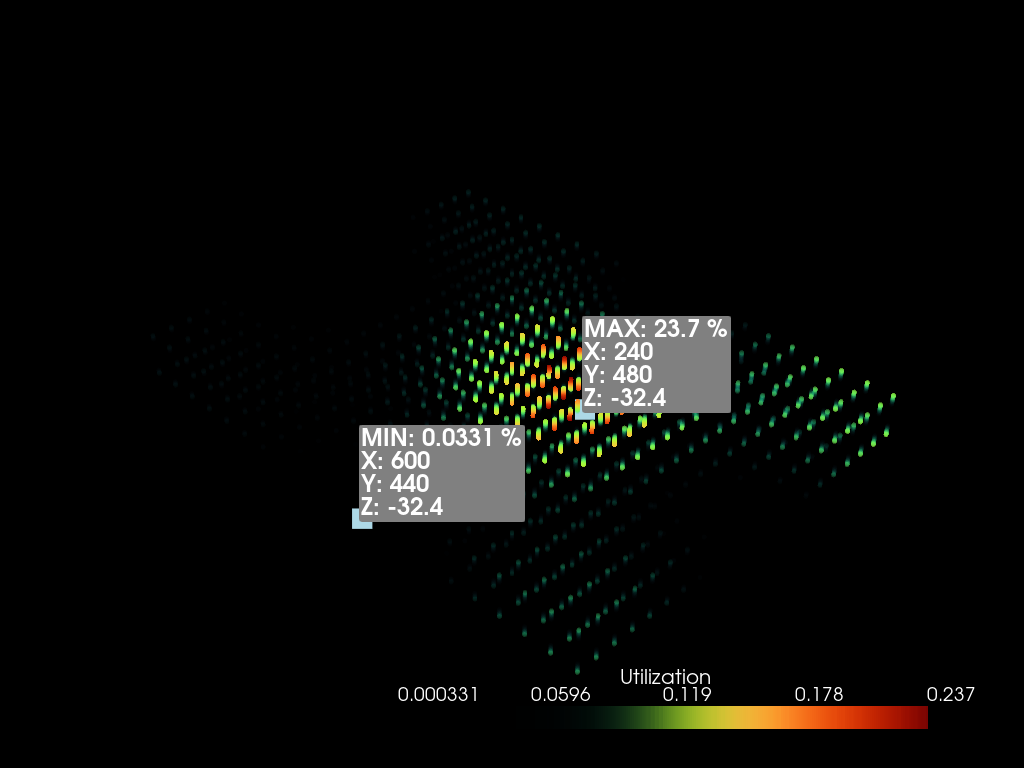

In [39]:
from sigmaepsilon.core.formatting import floatformatter 
from pyvista import themes

formatter = floatformatter(sig=3)

pv.set_plot_theme(themes.DarkTheme())

plotter = pv.Plotter(notebook=True)

scalars = util
points = util_coords
max_index = np.argmax(scalars)
min_index = np.argmin(scalars)

p_min = point_cloud.points[min_index]
p_max = point_cloud.points[max_index]
label_coords = np.array([p_min, p_max])

labels = [
    (
        f"MIN: {formatter.format(util.min()*100)} %"
        f"\nX: {formatter.format(points[min_index, 0])}"
        f"\nY: {formatter.format(points[min_index, 1])}"
        f"\nZ: {formatter.format(points[min_index, 2])}"
    ), 
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {formatter.format(points[max_index, 0])}"
        f"\nY: {formatter.format(points[max_index, 1])}"
        f"\nZ: {formatter.format(points[max_index, 2])}"
        )
]

plotter.add_mesh(
    point_cloud,
    scalars='scalars',
    cmap="turbo",
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24, always_visible=True)

plotter.show(jupyter_backend="static")